In [1]:
#数据路径设置
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
DATA_DIR = '..\camvid' # 根据自己的路径来设置

x_train_dir = os.path.join(DATA_DIR, 'train_images')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'valid_images')
y_valid_dir = os.path.join(DATA_DIR, 'valid_labels')

x_test_dir = os.path.join(DATA_DIR, 'test_images')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

print(x_train_dir, y_train_dir, x_valid_dir, y_valid_dir, x_test_dir, y_test_dir)

..\camvid\train_images ..\camvid\train_labels ..\camvid\valid_images ..\camvid\valid_labels ..\camvid\test_images ..\camvid\test_labels


In [2]:
#数据加载类，用于训练、验证、测试时提供数据加载支持
import torch
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    CLASSES = ['animal', 'archway', 'bicyclist', 'bridge', 'building', 'car', 'cartluggagepram',
               'child', 'column_pole', 'fence', 'lanemkgsdriv', 'lanemkgsnondriv',
               'misc_text', 'motorcyclescooter', 'othermoving', 'parkingblock', 'pedestrian',
               'road', 'roadshoulder', 'sidewalk', 'signsymbol', 'sky', 'suvpickuptruck',
               'trafficcone', 'trafficlight', 'train', 'tree', 'truck_bus', 'tunnel', 'vegetationmisc', 
               'void', 'wall']
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None,
            augmentation=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        '''for content in self.class_values:
            print('self.class_values:', content)'''
        
        self.augmentation = augmentation

    
    def __getitem__(self, i):
                
        # read data
        #print("ids: %d" % i)
        #由于anaconda会在各个目录添加.ipynb_check...的文件，当当前读取的文件名称不是png文件时,重新随机读取文件
        while self.images_fps[i][-4:] != '.png':
            #print('%s is not a png file!' % self.images_fps[i])
            i = random.randint(0,len(self.ids) - 1)
            #print('try to use file %s.' % self.images_fps[i])
        if self.images_fps[i].split('\\')[-1] != self.images_fps[i].split('\\')[-1]:
            print('error: label:%s is not match to images:%s' % (self.images_fps[i].split('\\')[-1], self.images_fps[i].split('\\')[-1]))
            os._exit() 
        #print(self.images_fps[i])
        #print(self.masks_fps[i])
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        #多分类
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        #为进行二分类，此处将label文件调整为只有road与背景的图片
        #mask = (mask==90)
        #mask = (mask==17)
        #mask = mask.astype('float')  
        #plt.imshow(mask)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        #return image, mask.reshape(len(self.class_values) + 1, 360, 480)
        
    def __len__(self):
        return len(self.ids)

0 255
491
imageshape: (360, 480, 3) maskshape: (360, 480, 3)


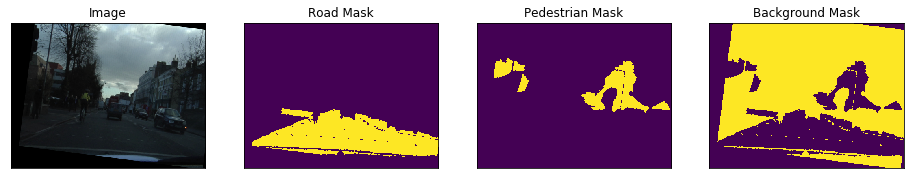

0 254
491
imageshape: (360, 480, 3) maskshape: (360, 480, 3)


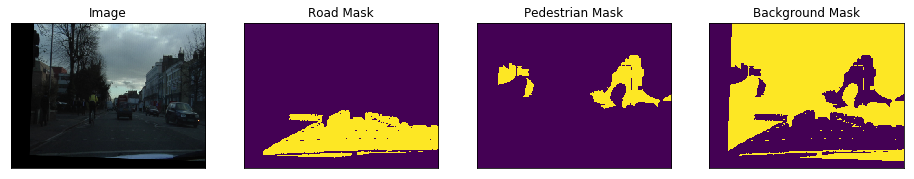

In [3]:
#### 定义图像增强函数以及图片展示函数
import albumentations as albu

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.Resize(height=360, width=480, always_apply=True),
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=20, shift_limit=0.1, p=1, border_mode=0),
    ]
    return albu.Compose(train_transform)

def get_test_augmentation():
    train_transform = [
        albu.Resize(height=360, width=480, always_apply=True),
    ]
    return albu.Compose(train_transform)       

def get_val_augmentation():
    train_transform = [
        albu.Resize(height=360, width=480, always_apply=True),
    ]
    return albu.Compose(train_transform)  

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=['Road', 'building'],
    augmentation=get_training_augmentation(), 
)

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# same image with different random transforms
for i in range(2):
    image, mask = augmented_dataset[16]
    print(np.min(image),np.max(image))
    print(len(augmented_dataset))
    print('imageshape:', image.shape, 'maskshape:', mask.shape)
    visualize(image=image, 
              road_mask=mask[..., 0].squeeze(),
              pedestrian_mask=mask[..., 1].squeeze(),
              background_mask=mask[..., 2].squeeze()
             )

In [4]:
#构建训练、验证数据集
CLASSES = ['Road', 'Car', 'Building', 'sky', 'tree', 'sidewalk', 'Pedestrian']
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES,
    augmentation=get_training_augmentation(), 
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES,
    augmentation=get_val_augmentation(), 
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)

n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1) 

In [5]:
#DFANet模型搭建
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

class FPA(nn.Module):
    def __init__(self, channels=2048):
        """
        Feature Pyramid Attention
        :type channels: int
        """
        super(FPA, self).__init__()
        channels_mid = int(channels/4)

        self.channels_cond = channels

        # Master branch
        self.conv_master = nn.Conv2d(self.channels_cond, channels, kernel_size=1, bias=False)
        self.bn_master = nn.BatchNorm2d(channels)

        # Global pooling branch
        self.conv_gpb = nn.Conv2d(self.channels_cond, channels, kernel_size=1, bias=False)
        self.bn_gpb = nn.BatchNorm2d(channels)

        # C333 because of the shape of last feature maps is (16, 16).
        self.conv7x7_1 = nn.Conv2d(self.channels_cond, channels_mid, kernel_size=(7, 7), stride=2, padding=3, bias=False)
        self.bn1_1 = nn.BatchNorm2d(channels_mid)
        self.conv5x5_1 = nn.Conv2d(channels_mid, channels_mid, kernel_size=(5, 5), stride=2, padding=2, bias=False)
        self.bn2_1 = nn.BatchNorm2d(channels_mid)
        self.conv3x3_1 = nn.Conv2d(channels_mid, channels_mid, kernel_size=(3, 3), stride=2, padding=1, bias=False)
        self.bn3_1 = nn.BatchNorm2d(channels_mid)

        self.conv7x7_2 = nn.Conv2d(channels_mid, channels_mid, kernel_size=(7, 7), stride=1, padding=3, bias=False)
        self.bn1_2 = nn.BatchNorm2d(channels_mid)
        self.conv5x5_2 = nn.Conv2d(channels_mid, channels_mid, kernel_size=(5, 5), stride=1, padding=2, bias=False)
        self.bn2_2 = nn.BatchNorm2d(channels_mid)
        self.conv3x3_2 = nn.Conv2d(channels_mid, channels_mid, kernel_size=(3, 3), stride=1, padding=1, bias=False)
        self.bn3_2 = nn.BatchNorm2d(channels_mid)

        # Convolution Upsample
        self.conv_upsample_3 = nn.ConvTranspose2d(channels_mid, channels_mid, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_upsample_3 = nn.BatchNorm2d(channels_mid)

        self.conv_upsample_2 = nn.ConvTranspose2d(channels_mid, channels_mid, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_upsample_2 = nn.BatchNorm2d(channels_mid)

        self.conv_upsample_1 = nn.ConvTranspose2d(channels_mid, channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_upsample_1 = nn.BatchNorm2d(channels)

        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        """
        :param x: Shape: [b, 2048, h, w]
        :return: out: Feature maps. Shape: [b, 2048, h, w]
        """
        # Master branch
        x_master = self.conv_master(x)
        x_master = self.bn_master(x_master)

        # Global pooling branch
        x_gpb = nn.AvgPool2d(x.shape[2:])(x).view(x.shape[0], self.channels_cond, 1, 1)
        x_gpb = self.conv_gpb(x_gpb)
        x_gpb = self.bn_gpb(x_gpb)

        # Branch 1
        #print('x:',x.shape)
        x1_1 = self.conv7x7_1(x)
        #print('after con7x7 x:',x1_1.shape)
        x1_1 = self.bn1_1(x1_1)
        x1_1 = self.relu(x1_1)
        x1_2 = self.conv7x7_2(x1_1)
        x1_2 = self.bn1_2(x1_2)

        # Branch 2
        x2_1 = self.conv5x5_1(x1_1)
        x2_1 = self.bn2_1(x2_1)
        x2_1 = self.relu(x2_1)
        x2_2 = self.conv5x5_2(x2_1)
        x2_2 = self.bn2_2(x2_2)

        # Branch 3
        x3_1 = self.conv3x3_1(x2_1)
        x3_1 = self.bn3_1(x3_1)
        x3_1 = self.relu(x3_1)
        x3_2 = self.conv3x3_2(x3_1)
        x3_2 = self.bn3_2(x3_2)

        # Merge branch 1 and 2
        x3_upsample = self.relu(self.bn_upsample_3(self.conv_upsample_3(x3_2)))
        
        diffY = torch.tensor([x3_upsample.size()[2] - x2_2.size()[2]])
        diffX = torch.tensor([x3_upsample.size()[3] - x2_2.size()[3]])
        x2_2 = F.pad(x2_2, [diffX // 2, diffX - diffX // 2, 
                          diffY // 2, diffY - diffY // 2])
        
        x2_merge = self.relu(x2_2 + x3_upsample)
        
        x2_upsample = self.relu(self.bn_upsample_2(self.conv_upsample_2(x2_merge)))

        diffY = torch.tensor([x2_upsample.size()[2] - x1_2.size()[2]])
        diffX = torch.tensor([x2_upsample.size()[3] - x1_2.size()[3]])
 
        x1_2 = F.pad(x1_2, [diffX // 2, diffX - diffX // 2, 
                          diffY // 2, diffY - diffY // 2])
    
        #print('x1_2 + x2_upsample:', x1_2.shape, x2_upsample.shape)
        x1_merge = self.relu(x1_2 + x2_upsample)
        
        x1_upsample = self.relu(self.bn_upsample_1(self.conv_upsample_1(x1_merge)))
        
        diffY = torch.tensor([x1_upsample.size()[2] - x_master.size()[2]])
        diffX = torch.tensor([x1_upsample.size()[3] - x_master.size()[3]])
 
        x_master = F.pad(x_master, [diffX // 2, diffX - diffX // 2, 
                          diffY // 2, diffY - diffY // 2])

        x_master = x_master * x1_upsample

        out = self.relu(x_master + x_gpb)

        return out

#可分离卷积
class SeparableConv2d(nn.Module):
    def __init__(self, inputChannel, outputChannel, kernel_size=3, stride=1, padding=1, dilation=1, bias=True):
        super(SeparableConv2d, self).__init__()
        self.conv1 = nn.Conv2d(inputChannel, inputChannel, kernel_size, stride, padding, dilation,
                               groups=inputChannel, bias=bias)
        self.pointwise = nn.Conv2d(inputChannel, outputChannel, 1, 1, 0, 1, 1, bias=bias)
    def forward(self, x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


# encoder block
class Block(nn.Module):
    """
    Base block for XceptionA and DFANet.
    inputChannel: channels of inputs of the base block.
    outputChannel:channnels of outputs of the base block.
    stride: stride
    BatchNorm:
    """
    def __init__(self, inputChannel, outputChannel,stride=1,BatchNorm=nn.BatchNorm2d):
        super(Block, self).__init__()

        self.conv1=nn.Sequential(SeparableConv2d(inputChannel,outputChannel//4,stride=stride,),
                                BatchNorm(outputChannel//4),
                                nn.ReLU())
        self.conv2=nn.Sequential(SeparableConv2d(outputChannel//4,outputChannel//4),
                                BatchNorm(outputChannel//4),
                                nn.ReLU())
        self.conv3=nn.Sequential(SeparableConv2d(outputChannel//4,outputChannel),
                                BatchNorm(outputChannel),
                                nn.ReLU())
        self.projection=nn.Conv2d(inputChannel,outputChannel,1,stride=stride,bias=False)
        
       
    def forward(self, x):
        out=self.conv1(x)
        out=self.conv2(out)
        out=self.conv3(out)
        identity=self.projection(x)
        return out+identity


class enc(nn.Module):
    """
    encoders:
    in_channels:The channels of input feature maps
    out_channnel:the channels of outputs of this enc.
    """
    def __init__(self,in_channels,out_channels,stride=2,num_repeat=3):
        super(enc, self).__init__()
        stacks=[Block(in_channels,out_channels,stride=2)]
        for x in range(num_repeat-1):
            stacks.append(Block(out_channels,out_channels))
        self.build=nn.Sequential(*stacks)
        # self.block1=Block(in_channels,out_channels,stride=2)
        # self.block2=Block(out_channels,out_channels)
        # self.block3=Block(out_channels,out_channels)
    def forward(self, x):
        x=self.build(x)
        # x=self.block2(x)
        # x=self.block3(x)
        return x

class Attention(nn.Module):
    """
    self attention model.
    """
    def __init__(self,in_channels,out_channels):
        super(Attention,self).__init__()
        self.avg_pool=nn.AdaptiveAvgPool2d(1)
        self.fc=nn.Sequential(
            nn.Linear(in_channels,1000,bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(1000, out_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self,x):
        b,c,_,_=x.size()
        y=self.avg_pool(x).view(b,c)
        y=self.fc(y).view(b,c,1,1)
        return x*y.expand_as(x)

        
class SubBranch(nn.Module):
    """
    channel_cfg: channels of the inputs of enc stage
    branch_index: 0,1,2,
    """
    def __init__(self,channel_cfg,branch_index):
        super(SubBranch,self).__init__()
        self.enc2=enc(channel_cfg[0],48,num_repeat=3)
        self.enc3=enc(channel_cfg[1],96,num_repeat=6)
        self.enc4=enc(channel_cfg[2],192,num_repeat=3)
        self.atten=Attention(192,192)
        self.atten_fpa=FPA(192)
        self.branch_index=branch_index
    
    def forward(self,x0,*args):
        out0=self.enc2(x0)
        if self.branch_index in [1,2]:
            out1=self.enc3(torch.cat([out0,args[0]],1))
            out2=self.enc4(torch.cat([out1,args[1]],1))
        else:
            out1=self.enc3(out0)
            out2=self.enc4(out1)
        if self.branch_index in [0,1]:
            out3=self.atten(out2)
        else:
            out3=self.atten_fpa(out2)
        return [out0,out1,out2,out3]    

class XceptionA(nn.Module):
    """
    channel_cfg:channels of inputs of enc block.
    n_classes:
    """
    def __init__(self,channel_cfg,n_classes):
        super(XceptionA, self).__init__()
        self.conv1=nn.Sequential(nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(num_features=8),
                                nn.ReLU())
        self.branch=SubBranch(channel_cfg,branch_index=0)
        self.avg_pool=nn.AdaptiveAvgPool2d(1)
    
        self.classifier=nn.Sequential(nn.Linear(192,1000),
                                      nn.ReLU(inplace=True),
                                      nn.Linear(1000,n_classes))
        for m in self.modules():
            weight_init(m)

    def forward(self,x):
        b,c,_,_=x.size()
        x=self.conv1(x)
        _,_,_,x=self.branch(x)
        x=self.avg_pool(x).view(b,-1)
        x=self.classifier(x)
        return x

class DFA_Encoder(nn.Module):
    """
    Encoder of DFANet.
    """
    def __init__(self,channel_cfg):
        super(DFA_Encoder,self).__init__()
        self.conv1=nn.Sequential(nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(num_features=8),
                                nn.ReLU())
        self.branch0=SubBranch(channel_cfg[0],branch_index=0)
        self.branch1=SubBranch(channel_cfg[1],branch_index=1)
        self.branch2=SubBranch(channel_cfg[2],branch_index=2)

    def forward(self,x):

        x=self.conv1(x)

        x0,x1,x2,x5=self.branch0(x)
        x3=F.interpolate(x5,x0.size()[2:],mode='bilinear',align_corners=True)
        x1,x2,x3,x6=self.branch1(torch.cat([x0,x3],1),x1,x2)
        x4=F.interpolate(x6,x1.size()[2:],mode='bilinear',align_corners=True)
        x2,x3,x4,x7=self.branch2(torch.cat([x1,x4],1),x2,x3)

        return [x0,x1,x2,x5,x6,x7]


class DFA_Decoder(nn.Module):
    """
        Decoder of DFANet.
    """
    def __init__(self,decode_channels,n_classes):
        super(DFA_Decoder,self).__init__()


        self.conv0=nn.Sequential(nn.Conv2d(in_channels=48,out_channels=decode_channels,kernel_size=1,bias=False),
                                 nn.BatchNorm2d(decode_channels),
                                 nn.ReLU(inplace=True))
        self.conv1=nn.Sequential(nn.Conv2d(in_channels=48,out_channels=decode_channels,kernel_size=1,bias=False),
                                 nn.BatchNorm2d(decode_channels),
                                 nn.ReLU(inplace=True))
        self.conv2=nn.Sequential(nn.Conv2d(in_channels=48,out_channels=decode_channels,kernel_size=1,bias=False),
                                 nn.BatchNorm2d(decode_channels),
                                 nn.ReLU(inplace=True))
        self.conv3=nn.Sequential(nn.Conv2d(in_channels=192,out_channels=decode_channels,kernel_size=1,bias=False),
                                 nn.BatchNorm2d(decode_channels),
                                 nn.ReLU(inplace=True))
        self.conv4=nn.Sequential(nn.Conv2d(in_channels=192,out_channels=decode_channels,kernel_size=1,bias=False),
                                 nn.BatchNorm2d(decode_channels),
                                 nn.ReLU(inplace=True))
        self.conv5=nn.Sequential(nn.Conv2d(in_channels=192,out_channels=decode_channels,kernel_size=1,bias=False),
                                 nn.BatchNorm2d(decode_channels),
                                 nn.ReLU(inplace=True))

        self.conv_add1=nn.Sequential(nn.Conv2d(in_channels=decode_channels,out_channels=decode_channels,kernel_size=3,padding=1),
                                 nn.BatchNorm2d(decode_channels),
                                 nn.ReLU(inplace=True))
                                

        self.conv_cls=nn.Conv2d(in_channels=decode_channels,out_channels=n_classes,kernel_size=3,padding=1,bias=False)

    def forward(self,x0,x1,x2,x3,x4,x5):

        x0=self.conv0(x0)
        x1=F.interpolate(self.conv1(x1),x0.size()[2:],mode='bilinear',align_corners=True)
        x2=F.interpolate(self.conv2(x2),x0.size()[2:],mode='bilinear',align_corners=True)
        x3=F.interpolate(self.conv3(x3),x0.size()[2:],mode='bilinear',align_corners=True)
        x4=F.interpolate(self.conv5(x4),x0.size()[2:],mode='bilinear',align_corners=True)
        x5=F.interpolate(self.conv5(x5),x0.size()[2:],mode='bilinear',align_corners=True)

        x_shallow=self.conv_add1(x0+x1+x2)

        x=self.conv_cls(x_shallow+x3+x4+x5)
        x=F.interpolate(x,scale_factor=4,mode='bilinear',align_corners=True)
        return x

class DFANet(nn.Module):
    def __init__(self,channel_cfg,decoder_channel,n_classes):
        super(DFANet,self).__init__()
        self.n_classes = n_classes
        self.encoder=DFA_Encoder(channel_cfg)
        self.decoder=DFA_Decoder(decoder_channel,n_classes)
        weight_init(self.encoder)
        weight_init(self.decoder)
    def forward(self,x):
        x0,x1,x2,x3,x4,x5=self.encoder(x)
        x=self.decoder(x0,x1,x2,x3,x4,x5)
        return x

def weight_init(module):
    #print('initialize  ',module._get_name())
    for n,m in module.named_children():
        if isinstance(m,nn.Conv2d):
            nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m,(nn.BatchNorm2d,nn.InstanceNorm2d)):
            nn.init.ones_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m,nn.Linear):
            nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m,(nn.Sequential,
                            SubBranch,
                            enc,Block,
                            SeparableConv2d,
                            Attention,
                            DFA_Encoder,
                            DFA_Decoder)):
            weight_init(m)
        elif isinstance(m,(nn.ReLU,nn.ReLU,nn.ReLU6)):
            pass
        else:
            pass

In [6]:
#DFANet模型测试
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ch_cfg=[[8,48,96],
        [240,144,288],
        [240,144,288]]


input = torch.randn(2, 3, 360, 480)
input=input.to(device)


#decoder test
#input=input.to(device)
net=DFANet(ch_cfg,64,n_classes)
net=net.to(device)
net(input)
start=time.time()
outputs=net(input)
end=time.time()

print(outputs.size())
print("inference time",end-start)
print("test DFANet sucessfully...")

torch.Size([2, 8, 360, 480])
inference time 0.15491104125976562
test DFANet sucessfully...


In [7]:
#搭建DFANet模型
class Config(object):
    
    NAME= "dfaNet"

    #set the output every STEP_PER_EPOCH iteration
    STEP_PER_EPOCH = 100
    ENCODER_CHANNEL_CFG=ch_cfg=[[8,48,96],
                                [240,144,288],
                                [240,144,288]]
cfg = Config()
net = DFANet(cfg.ENCODER_CHANNEL_CFG,decoder_channel=64,n_classes=n_classes)

In [8]:
print(net)

DFANet(
  (encoder): DFA_Encoder(
    (conv1): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (branch0): SubBranch(
      (enc2): enc(
        (build): Sequential(
          (0): Block(
            (conv1): Sequential(
              (0): SeparableConv2d(
                (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=8)
                (pointwise): Conv2d(8, 12, kernel_size=(1, 1), stride=(1, 1))
              )
              (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (conv2): Sequential(
              (0): SeparableConv2d(
                (conv1): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=12)
                (pointwise): Conv2d(12, 12, kernel_size=(1, 1), stride=(

)


Road
0.0 1.0


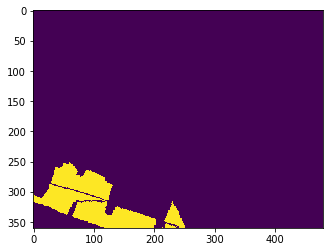

Car
0.0 1.0


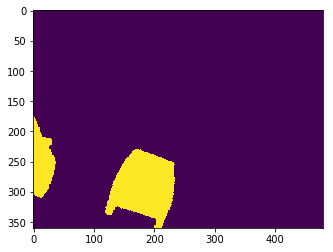

Building
0.0 1.0


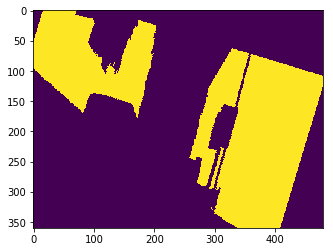

sky
0.0 1.0


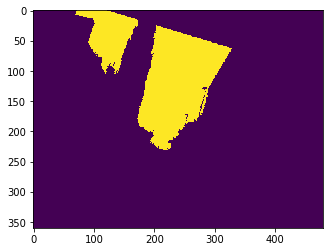

tree
0.0 1.0


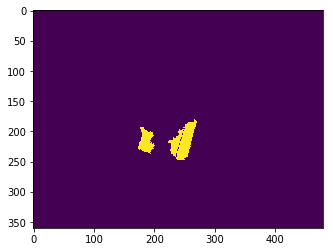

sidewalk
0.0 1.0


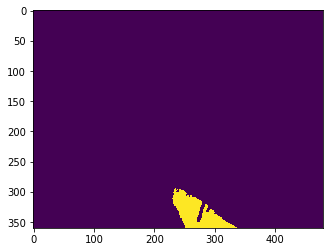

Pedestrian
0.0 1.0


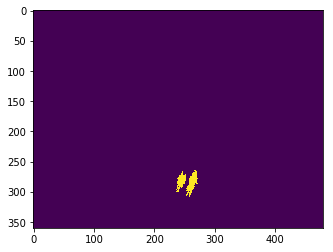

pred.shape: torch.Size([1, 8, 360, 480])
-4.6022707e+24 6.573305e+24


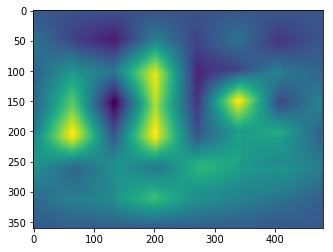

In [9]:
#数据集类别提取以及展示
image, mask = train_dataset[1]
net.eval()
with torch.no_grad():
    net.to('cuda')
    image = image/255.
    image = image.astype('float32')
    image = torch.from_numpy(image)
    image = image.permute(2,0,1)
    image = image.to()
    
    pred = net(image.unsqueeze(0).cuda())
    pred = pred.cpu()
for cnt in range(len(CLASSES)):
    print(CLASSES[cnt])
    plt.figure('mask')
    #print('mask.shape', mask.shape)
    #print('mask:', mask[..., 0])
    print(np.min(mask),np.max(mask))
    #plt.imshow(mask[0,:,:])
    plt.imshow(mask[..., cnt].squeeze())
    plt.show()

plt.figure('pred')
#pred = pred > 0.5
print('pred.shape:', pred.shape)
print(np.min(pred.numpy()),np.max(pred.numpy()))
plt.imshow(pred[0,0,:,:])
plt.show()

In [10]:
#对预测结果进行mIoU计算
import torch
import numpy as np
def Iou(input,target,classNum):
    '''
    :param input: [b,h,w]
    :param target: [b,h,w]
    :param classNum: scalar
    :return:
    '''
    inputTmp = torch.zeros([input.shape[0],classNum,input.shape[1],input.shape[2]])#创建[b,c,h,w]大小的0矩阵
    targetTmp = torch.zeros([target.shape[0],classNum,target.shape[1],target.shape[2]])#同上
    input = input.unsqueeze(1)#将input维度扩充为[b,1,h,w]
    target = target.unsqueeze(1)#同上
    
    inputOht = inputTmp.scatter_(index=input,dim=1,value=1)#input作为索引，将0矩阵转换为onehot矩阵
    targetOht = targetTmp.scatter_(index=target,dim=1,value=1)#同上
    batchMious = []#为该batch中每张图像存储一个miou
    total_miou = 0.
    #print('in iou \n inputOht:', inputOht.shape, '\n targetOht:', targetOht.shape)
    mul = inputOht * targetOht#乘法计算后，其中1的个数为intersection
    for i in range(input.shape[0]):#遍历图像
        ious = []
        for j in range(classNum):#遍历类别，包括背景
            intersection = torch.sum(mul[i][j])
            union = torch.sum(inputOht[i][j]) + torch.sum(targetOht[i][j]) - intersection + 1e-6
            iou = intersection / union
            ious.append(iou)
        miou = np.mean(ious)#计算该图像的miou
        #batchMious.append(miou)
        total_miou += miou
    return total_miou / input.shape[0]

In [11]:
#评估模型在验证集上的mIoU
import torch
import torch.nn.functional as F
#from tqdm import tqdm


def eval_net(net, loader, device):
    """return mIoU in the module of valid_data """
    net.eval()
    mask_type = torch.float32 if net.n_classes == 1 else torch.long
    #mask_type = torch.float32
    n_val = len(loader)  # the number of batch
    tot = 0
    mIoU = 0
    cnt = 0

    for image, label in loader:
        with torch.no_grad():
            image = image.permute(0,3,1,2)
            image = image.to(device=device, dtype=torch.float32)
            image = image/255
            mask = label.to(device=device, dtype=mask_type)
            #print('image:', image.shape, '\n', image)
            
            pred = net(image)
        #print('pred.shape:', pred.shape, pred)
        if net.n_classes > 1:
            mask = torch.topk(mask, 1)[1].squeeze(1)
            #print('in eval \n  mask:',mask.shape, mask)
            mask = mask[..., 0].cpu()
            
            pred = pred.permute(0, 2, 3, 1)
            pred = torch.topk(pred, 1)[1].squeeze(1)
            #print('in eval \n  pred:',pred.shape, pred)
            pred = pred[..., 0].cpu()
            #pred = pred.permute(2, 0, 1).cpu()
            
            miou = Iou(mask, pred, net.n_classes)
            cnt += 1
            print('cnt: %d miou : %f' % (cnt, miou), end='\r')
            sys.stdout.flush()
            tot += miou
        else:
            pred = torch.sigmoid(mask_pred)
            pred = (pred > 0.5).float()
            tot += dice_coeff(pred, true_masks).item()
    return tot / cnt

In [12]:
#在验证集上进行loss计算
def eval_val_loss(net, loader, device):
    criterion = nn.CrossEntropyLoss()
    net.eval()
    mask_type = torch.float32 if net.n_classes == 1 else torch.long
    #mask_type = torch.float32
    n_val = len(loader)  # the number of batch
    tot = 0.
    cnt = 0
    
    for data in loader:
        with torch.no_grad():
            images,labels = data
            images = images.permute(0, 3, 1, 2)
            images = Variable(images.to(device=device, dtype=torch.float32))
            images = images/255.
            mask_type = torch.float32 if net.n_classes == 1 else torch.long
            labels = Variable(labels.to(device=device, dtype=mask_type))
            pred = net(images)
            
            labels = torch.topk(labels, 1)[1].squeeze(1)
            labels = labels[:, :, :, 0]
            #print('cnt:', cnt, 'predshape:',pred.shape， pred, 'labelshape:', labels.shape, labels)
            loss = criterion(pred, labels)
            print('val-cnt-%d-loss: %f' % (cnt, loss.item()), end='\r')
            sys.stdout.flush()
            tot += loss.item()
            cnt += 1
    return tot / cnt

In [13]:
#删除tensorboard中的log文件，避免出现显示错误
import os
print('deal with train loss file')
logfile_dir = "runs/UNet_train_log"
logfile_ids = os.listdir(logfile_dir)
logfile_fps = [os.path.join(logfile_dir, logfile_id) for logfile_id in logfile_ids]
for i in range(len(logfile_ids)):
    print('file %d : %s' % (i, logfile_fps[i]))
for i in range(len(logfile_ids)):
    print('try to deal with file: %s' % logfile_fps[i])
    if logfile_fps[i][-6:] == 'points' or logfile_fps[i][-6:] == '_train' or logfile_fps[i][-6:] == '_valid':
        print('do not delete file: %s' % logfile_fps[i])
        continue
    print('delete logfile: %s', logfile_fps[i])
    os.remove(logfile_fps[i])

print('\n deal with epoch_loss_train flie')
logfile_dir = "runs/UNet_train_log/epoch_loss_train"
logfile_ids = os.listdir(logfile_dir)
logfile_fps = [os.path.join(logfile_dir, logfile_id) for logfile_id in logfile_ids]
for i in range(len(logfile_ids)):
    print('file %d : %s' % (i, logfile_fps[i]))
for i in range(len(logfile_ids)):
    print('try to deal with file: %s' % logfile_fps[i])
    if logfile_fps[i][-6:] == 'points' or logfile_fps[i][-6:] == '_train' or logfile_fps[i][-6:] == '_valid':
        print('do not delete file: %s' % logfile_fps[i])
        continue
    print('delete logfile: %s', logfile_fps[i])
    os.remove(logfile_fps[i])

print('\n deal with epoch_loss_valid flie')
logfile_dir = "runs/UNet_train_log/epoch_loss_valid"
logfile_ids = os.listdir(logfile_dir)
logfile_fps = [os.path.join(logfile_dir, logfile_id) for logfile_id in logfile_ids]
for i in range(len(logfile_ids)):
    print('file %d : %s' % (i, logfile_fps[i]))
for i in range(len(logfile_ids)):
    print('try to deal with file: %s' % logfile_fps[i])
    if logfile_fps[i][-6:] == 'points' or logfile_fps[i][-6:] == '_train' or logfile_fps[i][-6:] == '_valid':
        print('do not delete file: %s' % logfile_fps[i])
        continue
    print('delete logfile: %s', logfile_fps[i])
    os.remove(logfile_fps[i])

print('\n deal with mIoU_train flie')
logfile_dir = "runs/UNet_train_log/mIoU_train"
logfile_ids = os.listdir(logfile_dir)
logfile_fps = [os.path.join(logfile_dir, logfile_id) for logfile_id in logfile_ids]
for i in range(len(logfile_ids)):
    print('file %d : %s' % (i, logfile_fps[i]))
for i in range(len(logfile_ids)):
    print('try to deal with file: %s' % logfile_fps[i])
    if logfile_fps[i][-6:] == 'points' or logfile_fps[i][-6:] == '_train' or logfile_fps[i][-6:] == '_valid':
        print('do not delete file: %s' % logfile_fps[i])
        continue
    print('delete logfile: %s', logfile_fps[i])
    os.remove(logfile_fps[i])
    
print('\n deal with mIoU_valid flie')
logfile_dir = "runs/UNet_train_log/mIoU_valid"
logfile_ids = os.listdir(logfile_dir)
logfile_fps = [os.path.join(logfile_dir, logfile_id) for logfile_id in logfile_ids]
for i in range(len(logfile_ids)):
    print('file %d : %s' % (i, logfile_fps[i]))
for i in range(len(logfile_ids)):
    print('try to deal with file: %s' % logfile_fps[i])
    if logfile_fps[i][-6:] == 'points' or logfile_fps[i][-6:] == '_train' or logfile_fps[i][-6:] == '_valid':
        print('do not delete file: %s' % logfile_fps[i])
        continue
    print('delete logfile: %s', logfile_fps[i])
    os.remove(logfile_fps[i])

deal with train loss file
file 0 : runs/UNet_train_log\.ipynb_checkpoints
file 1 : runs/UNet_train_log\epoch_loss_train
file 2 : runs/UNet_train_log\epoch_loss_valid
file 3 : runs/UNet_train_log\events.out.tfevents.1590453336.DESKTOP-96ILCK0.1396.0
file 4 : runs/UNet_train_log\mIoU_train
file 5 : runs/UNet_train_log\mIoU_valid
try to deal with file: runs/UNet_train_log\.ipynb_checkpoints
do not delete file: runs/UNet_train_log\.ipynb_checkpoints
try to deal with file: runs/UNet_train_log\epoch_loss_train
do not delete file: runs/UNet_train_log\epoch_loss_train
try to deal with file: runs/UNet_train_log\epoch_loss_valid
do not delete file: runs/UNet_train_log\epoch_loss_valid
try to deal with file: runs/UNet_train_log\events.out.tfevents.1590453336.DESKTOP-96ILCK0.1396.0
delete logfile: %s runs/UNet_train_log\events.out.tfevents.1590453336.DESKTOP-96ILCK0.1396.0
try to deal with file: runs/UNet_train_log\mIoU_train
do not delete file: runs/UNet_train_log\mIoU_train
try to deal with file

In [14]:
#使用tensorboard对训练过程进行可视化
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/UNet_train_log')


In [15]:
torch.save(net.state_dict(), 'DFA-spp_model/train_epoch.pth')

In [18]:
x = torch.rand(2, 3, 360, 480)
with SummaryWriter(comment='DFANet') as w:
    w.add_graph(net, x.cuda())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call 

In [15]:
from torch.autograd import Variable
from torch import optim
import time

start_epoch = 0
resume = False #是否进行断点续训

#optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=0.9, weight_decay=0.00001)
optimizer = optim.Adam(net.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.00001)

#加载需要继续训练的模型以及参数
if resume:
    print('进行断点续训。')
    if os.path.isfile('DFA-spp_model/checkpoint'):
        checkpoint = torch.load('DFA-spp_model/checkpoint')
        start_epoch = checkpoint['epoch'] + 1
        net.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint (epoch {})".format(checkpoint['epoch']))
    else:
        print("=> no checkpoint found")
else:
    print('进行初始训练。')

batch_size = 4
epochs1 = 1000 
write_log_num = 10
# best_loss统计，初始化为正无穷
train_best_loss = float('inf')
valid_best_loss = 0.
train_old_model = ''
train_new_model = ''
valid_old_model = ''
valid_new_model = ''
path_checkpoint = ''

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
miou_train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)
print('dataloader ready!')
train_sum = len(train_loader)
net.cuda()
#optimizer = optim.RMSprop(net.parameters(), lr=0.01, weight_decay=1e-8,  momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.05, weight_decay=1e-8)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4)
def poly_lr_scheduler(epoch, num_epochs=epochs1, power=0.95):
  #print('学习率调整函数中 epoch:%d' % epoch)
  return power**(epoch//10)

def test_poly_lr_scheduler(epoch, num_epochs=epochs1, power=1.1659144):
  #print('学习率调整函数中 epoch:%d' % epoch)
  return power**epoch

scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=test_poly_lr_scheduler, last_epoch=start_epoch-1)

criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('parameters set up!')
print('start to train!')
for epoch in range(start_epoch, epochs1):
    start = time.process_time()
    net.train()
    log_loss = 0 #每次进行tensorboard记录时的总loss
    epoch_loss = 0 #每一个epoch后的总loss
    cnt = 1
    
    for data in train_loader:
        optimizer.zero_grad()
        images,labels = data
        images = images.permute(0, 3, 1, 2)
        images = Variable(images.to(device=device, dtype=torch.float32))
        images = images/255.
        mask_type = torch.float32 if net.n_classes == 1 else torch.long
        labels = Variable(labels.to(device=device, dtype=mask_type))
        pred = net(images)
         
        labels = torch.topk(labels, 1)[1].squeeze(1)
        labels = labels[:, :, :, 0]
        #print('cnt:', cnt, 'predshape:',pred.shape, 'labelshape:', labels.shape)
        loss = criterion(pred, labels)

        epoch_loss += loss.item()
        loss.backward()
        writer.add_scalar('loss_iter', loss.item(), cnt)
        writer.add_scalar('lr_iter', optimizer.param_groups[0]['lr'], cnt)
        print('cnt: %d, loss: %f, lr:%f' % (cnt, loss.item(), optimizer.param_groups[0]['lr']))
        optimizer.step() 
        scheduler.step() 
        if optimizer.param_groups[0]['lr'] > 0.1 :
            os.exit()
        #print('epoch-%d-cnt-%d-loss: %f' % ( (epoch + 1), cnt, loss.item()), end='\r')
        #sys.stdout.flush()
        cnt += 1
        '''if cnt > 10:
            break'''
    
    
    scheduler.step()   
    print('epoch-%d-epoch_avg_train_loss: %f' % ( (epoch + 1), epoch_loss / train_sum))
    end = time.process_time()
    print('epoch %d cost time %f seconds' % ((epoch + 1, (end - start))))
    #计算模型在验证集上的损失
    val_loss = eval_val_loss(net, valid_loader, device)

    print('epoch-%d-epoch_avg_val_loss: %f' % ( (epoch + 1), val_loss))
    writer.add_scalars('epoch_loss', {'train': epoch_loss / train_sum, 'valid': val_loss}, (epoch + 1))

    #保存在验证集上损失最低模型
    if val_loss < train_best_loss and val_loss < 0.4:
        train_best_loss = val_loss
        train_old_model = train_new_model
        train_new_model = 'DFA-spp_model/train_epoch-' + str(epoch+1) + '-loss_valid-' + str(val_loss) + '.pth'
        torch.save(net.state_dict(), 'DFA-spp_model/train_epoch-' + str(epoch+1) + '-loss_valid-' + str(val_loss) + '.pth')
        if train_old_model != '':
            print(train_old_model)
            os.remove(train_old_model)
    train_score = eval_net(net, miou_train_loader, device)
    print('avg_train_mIoU: %f' % train_score)
    #writer.add_scalar('train_mIoU', train_score, epoch + 1)
    val_score = eval_net(net, valid_loader, device)
    
    if val_score > valid_best_loss and val_score > 0.3:
      #保存最优mIoU的模型的参数，以便进行断点续训
        if path_checkpoint != '':
            os.remove(path_checkpoint)
        save_checkpoint = {
              'epoch': epoch,
              'model': net.state_dict(),
              'optimizer': optimizer.state_dict(),
          }
        torch.save(save_checkpoint, 'DFA-spp_model/checkpoint')
        #保存最优模型
        path_checkpoint = 'DFA-spp_model/checkpoint'
        valid_best_loss = val_score
        valid_old_model = valid_new_model
        valid_new_model = 'DFA-spp_model/valid_epoch-' + str(epoch+1) + '-valid_mIoU-' + str(val_score) + '.pth'
        torch.save(net.state_dict(), 'DFA-spp_model/valid_epoch-' + str(epoch+1) + '-valid_mIoU-' + str(val_score) + '.pth')
        if valid_old_model != '':
            print(valid_old_model)
            os.remove(valid_old_model)
    print('avg_val_mIoU: %f' % val_score)
    #scheduler.step(val_score)
    writer.add_scalars('mIoU', {'valid': val_score, 'train': train_score}, epoch + 1)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch + 1)
    end = time.process_time()
    print('epoch %d cost time %f seconds' % ((epoch + 1, (end - start))))

进行初始训练。
dataloader ready!
parameters set up!
start to train!
cnt: 1, loss: 2.971151, lr:0.000010
cnt: 2, loss: 2.501896, lr:0.000012
cnt: 3, loss: 2.728155, lr:0.000014
cnt: 4, loss: 2.560276, lr:0.000016
cnt: 5, loss: 2.325503, lr:0.000018
cnt: 6, loss: 2.532575, lr:0.000022
cnt: 7, loss: 2.502748, lr:0.000025
cnt: 8, loss: 2.816827, lr:0.000029
cnt: 9, loss: 2.516681, lr:0.000034
cnt: 10, loss: 2.474512, lr:0.000040
cnt: 11, loss: 2.384987, lr:0.000046
cnt: 12, loss: 1.957881, lr:0.000054
cnt: 13, loss: 2.125371, lr:0.000063
cnt: 14, loss: 2.051738, lr:0.000074
cnt: 15, loss: 2.391421, lr:0.000086
cnt: 16, loss: 2.229725, lr:0.000100
cnt: 17, loss: 1.857966, lr:0.000117
cnt: 18, loss: 1.795682, lr:0.000136
cnt: 19, loss: 2.001238, lr:0.000158
cnt: 20, loss: 2.001434, lr:0.000185
cnt: 21, loss: 1.987184, lr:0.000215
cnt: 22, loss: 1.965570, lr:0.000251
cnt: 23, loss: 1.883565, lr:0.000293
cnt: 24, loss: 1.984682, lr:0.000341
cnt: 25, loss: 1.656006, lr:0.000398
cnt: 26, loss: 1.498730

AttributeError: module 'os' has no attribute 'exit'

load model
done
model test
done
imageshape: torch.Size([3, 360, 480])


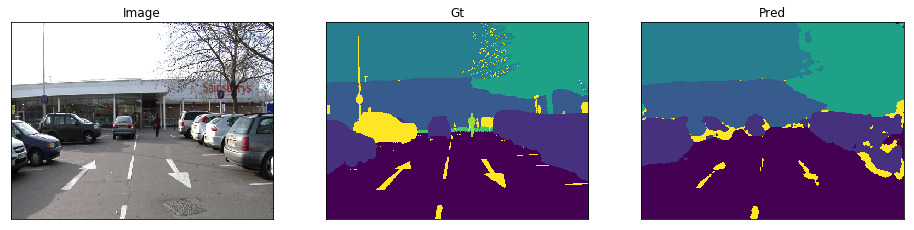

imageshape: torch.Size([3, 360, 480])


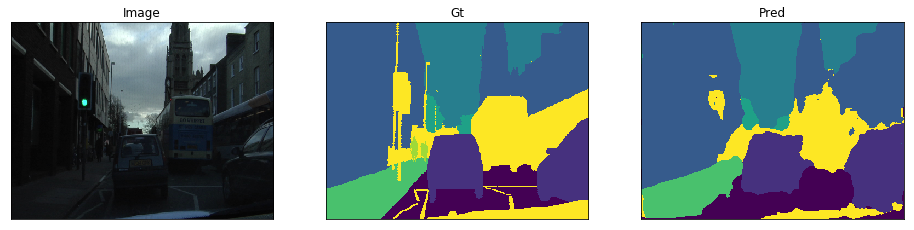

imageshape: torch.Size([3, 360, 480])


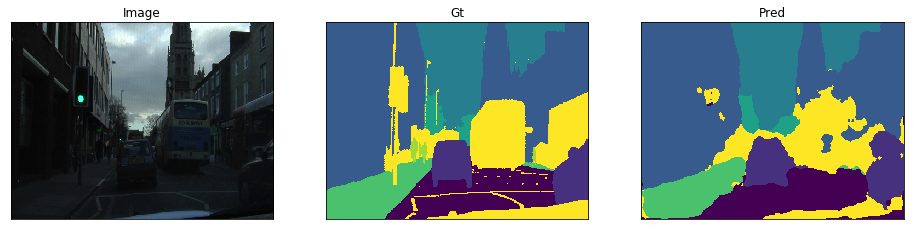

imageshape: torch.Size([3, 360, 480])


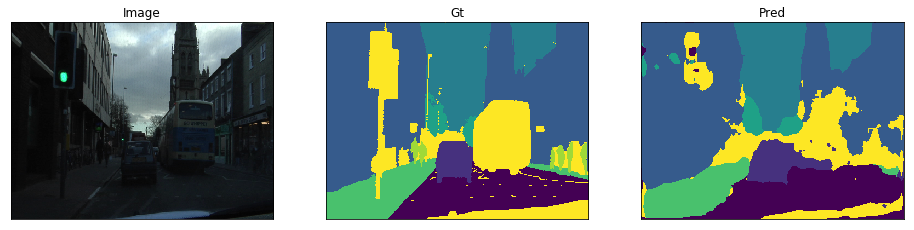

imageshape: torch.Size([3, 360, 480])


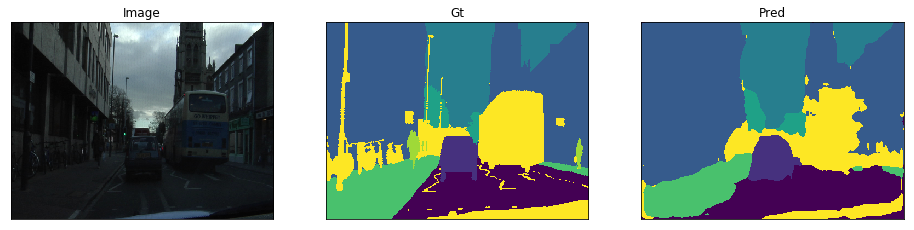

imageshape: torch.Size([3, 360, 480])


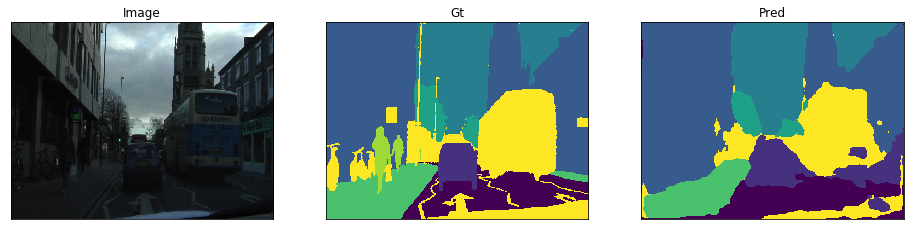

imageshape: torch.Size([3, 360, 480])


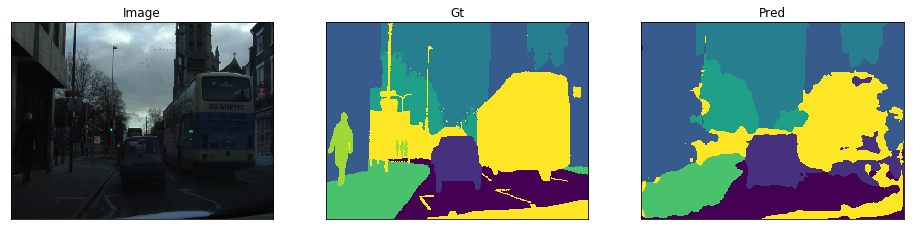

imageshape: torch.Size([3, 360, 480])


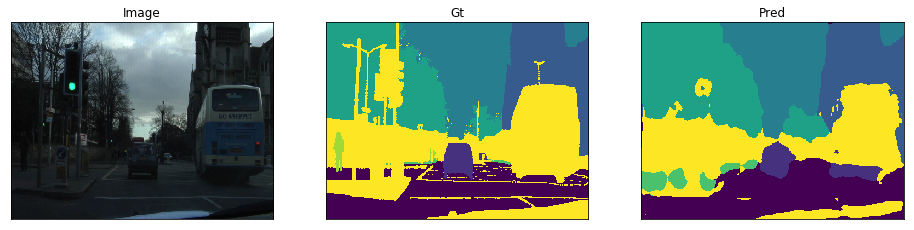

imageshape: torch.Size([3, 360, 480])


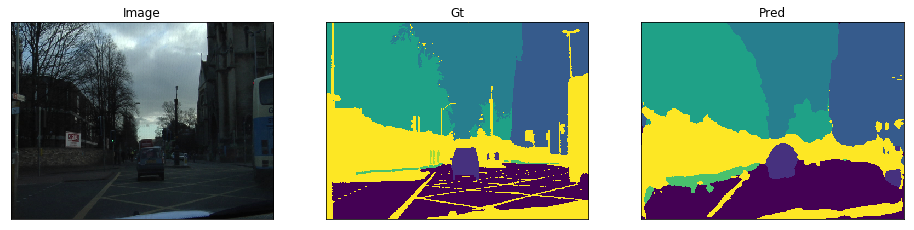

imageshape: torch.Size([3, 360, 480])


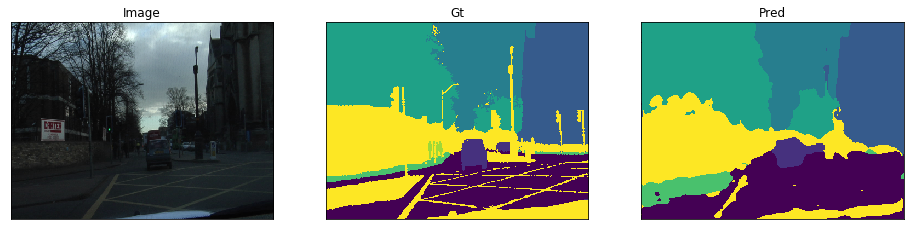

imageshape: torch.Size([3, 360, 480])


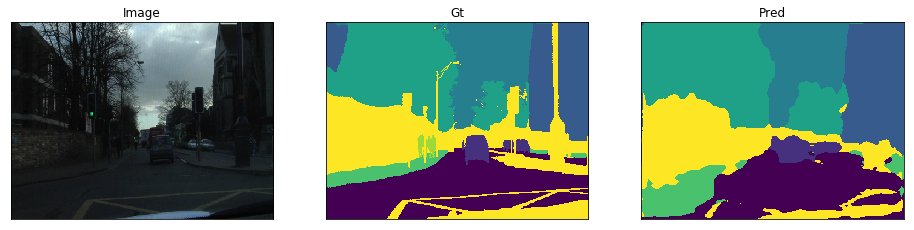

In [17]:
 # 测试
from torchvision import transforms
from PIL import Image
test_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    classes=CLASSES,
    augmentation=get_test_augmentation(),
    )
cnt = 0
# 选择设备，有cuda用cuda，没有就用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 加载网络，图片单通道，分类为1。
net = DFANet(cfg.ENCODER_CHANNEL_CFG,decoder_channel=64,n_classes=n_classes)
# 将网络拷贝到deivce中
net.to(device=device)
# 加载模型参数
print('load model')
net.load_state_dict(torch.load('DFA-spp_model/valid_epoch-601-valid_mIoU-0.5709024405905179.pth', map_location=device))
print('done')
# 测试模式
print('model test')
net.eval()
print('done')

for num in range(len(test_dataset)):
    image, mask = test_dataset[num]
    show_image = image
    
    with torch.no_grad():
        image = image/255.
        image = image.astype('float32')
        image = torch.from_numpy(image)
        image = image.permute(2,0,1)
        image = image.to()
        print('imageshape:', image.shape)

        pred = net(image.unsqueeze(0).cuda())
        '''if net.n_classes > 1:
            pred = F.softmax(pred, dim=1)
            
        pred = pred.cpu()
        if net.n_classes > 1:
            pred = pred.permute(2, 3, 1, 0)'''
        mask = torch.from_numpy(mask)
        mask = torch.topk(mask, 1)[1].squeeze(1)
        mask = mask[..., 0].cpu()
        
        pred = pred.permute(2, 3, 1, 0)
        pred = torch.topk(pred[..., 0], 1)[1].squeeze(1)
        pred = pred[..., 0].cpu()
        #pred = pred.permute(2, 0, 1).cpu()
    #print(len(pred), len(pred[0]), len(pred[0, 0]))
    #print('pred:',pred.shape, pred)
    #print('mask:',mask.shape, mask)
    visualize(image=show_image,GT=mask,Pred=pred)
    cnt += 1
    if cnt > 10:
        break